In [1]:
import numpy as np
import scipy.optimize
import os
import re
import json
import matplotlib.pyplot as plt
import PIL

In [127]:
tmp_dir = os.path.join(
    os.environ["USERPROFILE"], "rzgdatashare", "RZG_Data",
    "20181109_SLD670_L4_MMF20-22-105_L11_L500_Coherence"
)
tail_name = "20181109_SLD670_Coherence_v_x_4920um"

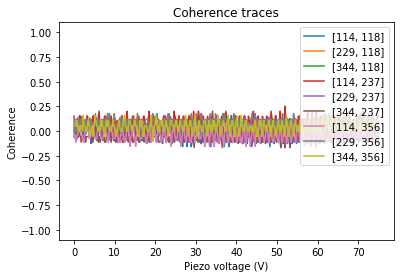

In [128]:
%matplotlib inline
# Cohtrace data
lines = []
with open(os.path.join(tmp_dir, tail_name, tail_name + "_cohtrace.txt")) as f:
    for line in f:
        if re.match(r"#*", line):
            lines.append(line.strip("# \r\n"))
header = None
for line in lines:
    try:
        header = json.loads(line)
    except ValueError as e:
        continue
    if type(header) == dict:
        break
assert(header is not None and
       "piezo_trace" in header.keys() and
       "cohtrace_coords" in header.keys() and
       "crop_coords" in header.keys())
unit = header["piezo_trace"]
cohtrace_coords = header["cohtrace_coords"]
crop_coords = header["crop_coords"]
cohtrace_coords = [
    [cohtrace_coords[it][0] - crop_coords[0][0],
     cohtrace_coords[it][1] - crop_coords[0][1]]
    for it in range(len(cohtrace_coords))
]
cohtraces = np.loadtxt(os.path.join(tmp_dir, tail_name, tail_name + "_cohtrace.txt"))
assert(len(cohtrace_coords) == len(cohtraces) - 1)
# Cohtrace fits
def gauss_env(x, scale, width, center):
    return scale * np.exp(-((x - center) / width)**2 / 2)
def gauss_env_list(x_list, scale, width, center):
    return np.array([gauss_env(xx, scale, width, center) for xx in x_list])
def gauss_osc(x, scale, width, center, freq, phase):
    return gauss_env(x, scale, width, center) * np.cos(freq * x + phase)
fit_params = []
for it in range(len(cohtraces) - 1):
    p0 = [np.max(cohtraces[it + 1]),
          (np.max(cohtraces[0]) - np.min(cohtraces[0])) / 2,
          cohtraces[0][np.argmax(cohtraces[it + 1])],
          1., 0.]
    # fit_params.append(np.abs(scipy.optimize.curve_fit(
    #     gauss_osc, cohtraces[0], cohtraces[it + 1], p0=p0
    # )[0]))
# x_fit = np.linspace(np.min(cohtraces[0]), np.max(cohtraces[0]), 300)
# y_fit = [gauss_env_list(x_fit, p[0], p[1], p[2]) for p in fit_params]
# Plots
for it in range(len(cohtraces) - 1):
    # label_str = "{:s}: {:.2f}, {:.1f}"
    # label_format = (str(cohtrace_coords[it]), fit_params[it][0], fit_params[it][1])
    label_str = "{:s}"
    label_format = (str(cohtrace_coords[it]), )
    plt.plot(cohtraces[0], cohtraces[it + 1],
             label=label_str.format(*label_format),
             color="C{:d}".format(it))
    # plt.plot(x_fit, y_fit[it], "C{:d}--".format(it))
    # plt.plot(x_fit, -y_fit[it], "C{:d}--".format(it))
plt.legend()
plt.xlabel("Piezo voltage (V)")
plt.ylabel("Coherence")
plt.ylim(-1.1, 1.1)
plt.title("Coherence traces")
plt.savefig(os.path.join(tmp_dir, tail_name, tail_name + "_cohtrace.pdf"))
plt.show()

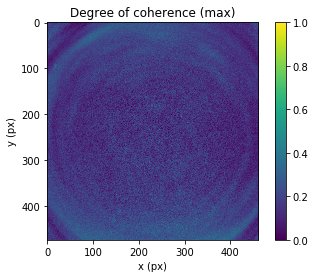

In [129]:
im_max = np.load(os.path.join(tmp_dir, tail_name, tail_name + "_imrec_max.npy"))
plt.imshow(im_max, vmin=0, vmax=1)
plt.colorbar()
plt.title("Degree of coherence (max)")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.savefig(os.path.join(tmp_dir, tail_name, tail_name + "_imrec_max.png"))
plt.show()

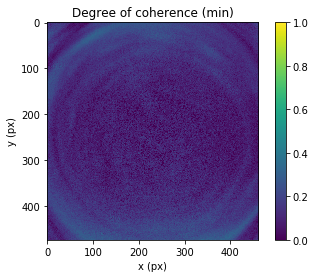

In [130]:
im_min = np.load(os.path.join(tmp_dir, tail_name, tail_name + "_imrec_min.npy"))
plt.imshow(-im_min, vmin=0, vmax=1)
plt.colorbar()
plt.title("Degree of coherence (min)")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.savefig(os.path.join(tmp_dir, tail_name, tail_name + "_imrec_min.png"))
plt.show()

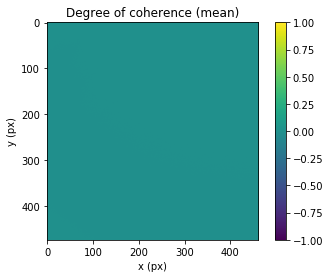

In [122]:
im_mean = np.load(os.path.join(tmp_dir, tail_name, tail_name + "_imrec_mean.npy"))
plt.imshow(im_mean, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Degree of coherence (mean)")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.savefig(os.path.join(tmp_dir, tail_name, tail_name + "_imrec_mean.png"))
plt.show()

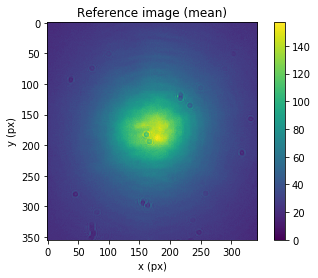

In [66]:
im_ref = np.load(os.path.join(tmp_dir, tail_name, tail_name + "_imref_mean.npy"))
plt.imshow(im_ref, vmin=0)
plt.colorbar()
plt.title("Reference image (mean)")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.savefig(os.path.join(tmp_dir, tail_name, tail_name + "_imref_mean.png"))
plt.show()

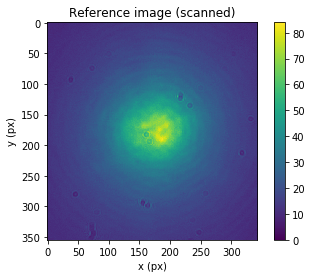

In [67]:
%matplotlib inline
im_ref_scanned = np.load(os.path.join(tmp_dir, tail_name, tail_name + "_imref_scanned.npy"))
plt.imshow(im_ref_scanned, vmin=0)
plt.colorbar()
plt.title("Reference image (scanned)")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
image = PIL.Image.fromarray(np.uint8(im_ref_scanned / im_ref_scanned.max() * 256), "L")
image.save(os.path.join(tmp_dir, tail_name, tail_name + "_imref_scanned.bmp"))
plt.show()

In [27]:
hist, bins, _ = plt.hist(-im_min.flatten(), bins=list(np.linspace(0.0, 0.2, 21)))
bins = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)])
def fit_func(x, A, x0, s, y0):
    return A * np.exp(-(x - x0)**2 / 2 / s**2) + y0
p, _ = scipy.optimize.curve_fit(fit_func, bins, hist)
y = fit_func(np.linspace(bins[0], bins[-1], 200), *p)
plt.plot(np.linspace(bins[0], bins[-1], 200), y, label="coherence: {:.3f}".format(p[1]))
plt.title("Coh. hist. at 500µm")
plt.xlabel("Coherence")
plt.ylabel("Counts")
plt.legend()
plt.show()